In [6]:
# path setting
EXP_NAME = "e017-use-all-inf-w-col-wo-sep"
MODEL_NAME = "microsoft/deberta-v3-xsmall"
COMPETITION_NAME = "atmacup17"

DATA_PATH = "data"
ENV_PATH = "env_file"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"
TARGET_COL = "Recommended IND"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
# UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
INFERENCE_MAX_LENGTH = 512
SEED = 42
EPOCH = 4
LR = 2e-04
TRAIN_BS = 8
GRAD_ACC_STEP = 128 // TRAIN_BS  # 仮想的なバッチサイズはTRAIN_BS * GRAD_ACC_STEPとなる
EVAL_BS = 8
NUM_LABELS = 2

USE_FOLD = 0  # Fold数は3(0, 1, 2)

In [7]:
!nvidia-smi

Fri Aug 30 04:33:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             40W /  300W |   11789MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!python --version

Python 3.10.14


In [9]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return "kernel", f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return "nohup", f"../../{base_path}"
    elif cwd == f"/content":
        print("Google Colab!")
        return "colab", f"/content/drive/MyDrive/Kaggle/{COMPETITION_NAME}/{base_path}"
    elif cwd.startswith("/home/shinichiro.saito"):
        print("GCP!")
        return "GCP", f"/home/shinichiro.saito/{COMPETITION_NAME}/{base_path}"
    else:
        raise Exception("Unknown environment")


ENV_NAME, DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
_, MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)
_, ENV_PATH = resolve_path(ENV_PATH)

/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/data
/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/trained_models/e017-use-all-inf-w-col-wo-sep
/home/shinichiro.saito/atmacup17/exp
GCP!


In [10]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [11]:
if ENV_NAME != "GCP":
    %pip install -qq polars==1.0.0
    %pip install -qq transformers==4.42.3
    %pip install -qq sentencepiece==0.2.0
    %pip install -qq datasets==2.20.0
    %pip install -qq evaluate==0.4.2
    %pip install -qq seqeval==1.2.2
    %pip install -qq accelerate==0.32.0
    %pip install -qq python-dotenv==1.0.1
    %pip install -qq wandb==0.17.4
    %pip install -qq bitsandbytes==0.43.1
    %pip install -qq accelerate==0.32.0
    %pip install -qq peft==0.11.1

    # formatter
    %pip install -qq black isort

    %pip install -qq kaggle

# import

In [12]:
import os
import random
import ast
import json

import polars as pl
import numpy as np
import torch
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import wandb
from datasets import (
    Dataset,
    DatasetDict,
    Value,
    concatenate_datasets,
    load_dataset,
    ClassLabel,
)
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
from tqdm.auto import tqdm
from scipy.special import softmax
from sklearn.metrics import log_loss
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    DebertaV2PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    ContextPooler,
    StableDropout,
    DebertaV2Model,
)

In [13]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()
NUM_PROC

8

In [14]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.42.3"
assert datasets.__version__ == "2.20.0"
assert evaluate.__version__ == "0.4.2"

In [15]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [16]:
from dotenv import load_dotenv

load_dotenv(f"{ENV_PATH}/.env")

True

# Wandb

In [17]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project=COMPETITION_NAME, name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sinchir0. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/shinichiro.saito/.netrc


'wandb'

# Data Import & Preprocess

In [18]:
with open(f"{DATA_PATH}/rec_stratified_fold.json") as f:
    label_stratified_fold = json.load(f)

In [19]:
train = (
    pl.read_csv(f"{DATA_PATH}/train_with_index.csv")
    .join(pl.read_csv(f"{DATA_PATH}/clothing_master.csv"), on="Clothing ID", how="left")
    .with_columns(
        pl.col("Title").fill_null(""),
        pl.col("Review Text").fill_null(""),
    )
    .rename({TARGET_COL: "label"})
    .with_columns(  # foldを追加する
        pl.col("index").replace(label_stratified_fold).alias("fold")
    )
)

test = (
    pl.read_csv(f"{DATA_PATH}/test.csv")
    .join(pl.read_csv(f"{DATA_PATH}/clothing_master.csv"), on="Clothing ID", how="left")
    .with_columns(
        pl.col("Title").fill_null(""),
        pl.col("Review Text").fill_null(""),
    )
)

In [20]:
if DEBUG:
    train = train.head(100)
    test = test.head(100)

In [21]:
train_dataset = Dataset.from_polars(train)
test_dataset = Dataset.from_polars(test)

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
)
model.resize_token_embeddings(len(tokenizer))

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenize

In [23]:
# def tokenize(examples, max_token_length: int):
#     separator = " [SEP] "

#     joined_text = examples["Title"] + separator + examples["Review Text"]

#     return tokenizer(
#         joined_text,
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


# def tokenize(examples, max_token_length: int):
#     return tokenizer(
#         examples["Title"],
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


# def tokenize(examples, max_token_length: int):
#     return tokenizer(
#         examples["Review Text"],
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


def use_all_info(examples) -> str:
    # separator = " [SEP] "
    return (
        "Title "
        + examples["Title"]
        + " "
        + "Review Text "
        + examples["Review Text"]
        + " "
        + "Positive Feedback Count "
        + str(examples["Positive Feedback Count"])
        + " "
        + "Age "
        + str(examples["Age"])
        + " "
        + "Division Name "
        + examples["Division Name"]
        + " "
        + "Department Name "
        + examples["Department Name"]
        + " "
        + "Class Name "
        + examples["Class Name"]
    )


def tokenize(examples, max_token_length: int):
    text = use_all_info(examples)

    return tokenizer(
        text,
        max_length=max_token_length,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

test_dataset = test_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/11155 [00:00<?, ? examples/s]

In [24]:
print(tokenizer.decode(train_dataset[0]["input_ids"]))

[CLS] Title 3-season skirt! Review Text Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops! Positive Feedback Count 4 Age 25 Division Name General Department Name Bottoms Class Name Skirts[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

In [25]:
print(tokenizer.decode(test_dataset[0]["input_ids"]))

[CLS] Title So happy i bought this skirt! Review Text I love this skirt. it does run a little small, i ordered an extra small and it is tight at the waist, but still works. i have received more compliments on this skirt than maybe anything i have owned. i've been stopped at the grocery store by people telling me how much they like it. i also work with kids, and they all love it as well. Positive Feedback Count 0 Age 32 Division Name General Department Name Bottoms Class Name Skirts[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD

# Train Test Split

In [26]:
filtered_train = train_dataset.filter(
    lambda x: x["fold"] != USE_FOLD, num_proc=NUM_PROC
)
filtered_valid = train_dataset.filter(
    lambda x: x["fold"] == USE_FOLD, num_proc=NUM_PROC
)

train_valid_dataset = DatasetDict(
    {
        "train": filtered_train,
        "valid": filtered_valid,
    }
)

del filtered_train, filtered_valid

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [27]:
print(train_valid_dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'label', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'fold', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6666
    })
    valid: Dataset({
        features: ['index', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'label', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'fold', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3334
    })
})


In [28]:
assert (
    set(train_valid_dataset["train"]["index"])
    & set(train_valid_dataset["valid"]["index"])
    == set()
)

In [29]:
from sklearn.metrics import roc_auc_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds_prob = softmax(predictions, axis=-1)
    return {"eval_roc_auc": roc_auc_score(labels, preds_prob[:, 1])}

In [30]:
# スケジューラの設定
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_STEP,
    eval_accumulation_steps=GRAD_ACC_STEP,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    save_total_limit=1,
    logging_steps=2,
    seed=SEED,
    metric_for_best_model="eval_roc_auc",
    greater_is_better=True,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_valid_dataset["train"],
    eval_dataset=train_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [31]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    # os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    pass
# else:
#     # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
#     model = AutoModelForSequenceClassification.from_pretrained(
#         TRAINED_MODEL_PATH,
#         num_labels=NUM_LABELS,
#     )

#     args = TrainingArguments(
#         ".",
#         per_device_eval_batch_size=4,
#         report_to="none",
#         fp16=True,
#     )

#     trainer = Trainer(
#         model=model,
#         args=args,
#         data_collator=data_collator,
#         tokenizer=tokenizer,
#     )

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Roc Auc
21,0.419200,0.496627,0.826544
42,0.329900,0.257752,0.945994
63,0.213100,0.216959,0.950601
84,0.230300,0.240036,0.948361
105,0.153200,0.224315,0.959026
126,0.145100,0.199425,0.957568
147,0.122400,0.228928,0.955993
168,0.131500,0.229412,0.954302
189,0.089200,0.232330,0.953505


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning

# valid_datasetの作成・保存

In [32]:
from sklearn.metrics import roc_auc_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds_prob = softmax(predictions, axis=-1)
    return {"eval_roc_auc": roc_auc_score(labels, preds_prob[:, 1])}

In [33]:
# TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
valid_dataset = train_dataset.filter(
    lambda example: example["index"] in train_valid_dataset["valid"]["index"],
    num_proc=NUM_PROC,
)

valid_dataset = valid_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = softmax(trainer.predict(valid_dataset).predictions, axis=-1)

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred[:, 1]}
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/3334 [00:00<?, ? examples/s]

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

In [34]:
(
    valid_dataset.to_polars()
    .select(pl.exclude("input_ids", "attention_mask", "token_type_ids"))
    .write_csv(f"{MODEL_OUTPUT_PATH}/valid_dataset_{EXP_NAME}.csv")
)

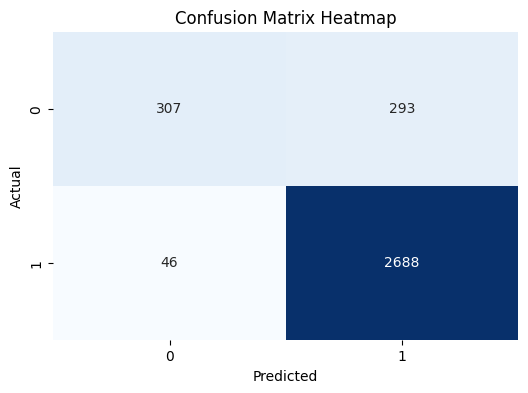

In [35]:
# 混同行列の作成
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 混同行列を作成
cm = confusion_matrix(valid_dataset["label"], valid_pred.argmax(axis=1))

# Seabornでヒートマップをプロット
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=[0, 1],
    yticklabels=[0, 1],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# CVの計算

In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(valid_dataset["label"], valid_pred.argmax(axis=1))

0.8983203359328135

In [37]:
cv_score = roc_auc_score(valid_dataset["label"], valid_pred[:, 1])
print(f"CV Score: {cv_score}")

CV Score: 0.959037734698854


In [38]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# テストに対する計算

In [39]:
test_dataset = test_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


test_pred = softmax(trainer.predict(test_dataset).predictions, axis=-1)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/11155 [00:00<?, ? examples/s]

# 提出ファイルの作成

In [40]:
sample_submission = pl.read_csv(f"{DATA_PATH}/sample_submission.csv")

if DEBUG:
    sample_submission = sample_submission.head(100)

(
    sample_submission.with_columns(
        pl.Series(test_pred[:, 1]).alias("target")
    ).write_csv(f"{MODEL_OUTPUT_PATH}/submission_{EXP_NAME}_cv{cv_score:.4f}.csv")
)

# AWSへのアップロード

In [41]:
# S3へのアップロード
# if not DEBUG and UPLOAD_DATA_TO_S3:
if UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://{COMPETITION_NAME}/trained_model/{output_name}"
    )

rm: cannot remove '/usr/bin/aws': No such file or directory
rm: cannot remove '/usr/bin/aws_completer': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58.0M  100 58.0M    0     0   153M      0 --:--:-- --:--:-- --:--:--  152M
You can now run: /usr/local/bin/aws --version
upload: ../trained_models/e017-use-all-inf-w-col-wo-sep/added_tokens.json to s3://atmacup17/trained_model/e017-use-all-inf-w-col-wo-sep/added_tokens.json
upload: ../trained_models/e017-use-all-inf-w-col-wo-sep/checkpoint-105/added_tokens.json to s3://atmacup17/trained_model/e017-use-all-inf-w-col-wo-sep/checkpoint-105/added_tokens.json
upload: ../trained_models/e017-use-all-inf-w-col-wo-sep/checkpoint-105/config.json to s3://atmacup17/trained_model/e017-use-all-inf-w-col-wo-sep/checkpoint-105/config.json
upload: ../trained_models/e017-use-all-inf-w-col-wo-sep/checkpoint-105/model.

In [42]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

In [43]:
if WANDB:
    wandb.finish()

eval/loss,█▂▁▂▂▁▂▂▂
eval/roc_auc,▁▇█▇█████
eval/runtime,▁▁█▇█▁▁▁█
eval/samples_per_second,█▇▁▁▁███▁
eval/steps_per_second,█▇▁▁▁███▁
test/eval_roc_auc,▁
test/loss,▁
test/runtime,▁█
test/samples_per_second,▁█
test/steps_per_second,▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [44]:
print("finish Notebook!")

finish Notebook!
